In [6]:
!pip install -U torch torchvision timm open_clip_torch matplotlib tqdm

In [7]:
import math, random, time
from collections import defaultdict
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Tuple, Optional

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import open_clip

# ------------------ Repro & Device ------------------
def seed_all(seed=42):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False  # True slows down a lot
    torch.backends.cudnn.benchmark = True

device = "cuda" if torch.cuda.is_available() else "cpu"
seed_all(42)

# ------------------ Metric history ------------------
class History:
    """Simple metric logger usable for train/val/test; plottable."""
    def __init__(self): self._log = defaultdict(list)
    def update(self, **metrics):
        for k,v in metrics.items(): self._log[k].append(float(v))
    def dict(self): return dict(self._log)
    def plot(self, keys: List[str]=None):
        keys = keys or list(self._log.keys())
        for k in keys:
            plt.figure(); plt.plot(self._log[k]); plt.title(k); plt.xlabel("step"); plt.ylabel(k); plt.show()

# ------------------ Visualization helpers ------------------
def viz_conv_kernels(conv: nn.Conv2d, max_k=64, title=None):
    """Show conv kernels as images (first max_k). Works for ViT patch-embed and CNN convs."""
    w = conv.weight.detach().cpu().clone()          # [out, in, kH, kW]
    k = min(max_k, w.shape[0])
    w = w[:k]

    # --- robust per-filter min/max (supports tuple dims) ---
    try:  # PyTorch 1.7+ path
        wmin = torch.amin(w, dim=(1, 2, 3), keepdim=True)
        wmax = torch.amax(w, dim=(1, 2, 3), keepdim=True)
    except TypeError:  # older fallback
        flat = w.view(w.size(0), -1)
        wmin = flat.min(dim=1)[0].view(-1, 1, 1, 1)
        wmax = flat.max(dim=1)[0].view(-1, 1, 1, 1)

    w = (w - wmin) / (wmax - wmin + 1e-8)

    # If input channels not RGB/gray, average for display
    w_disp = w if w.shape[1] in (1, 3) else w.mean(1, keepdim=True)

    grid = make_grid(w_disp, nrow=int(math.sqrt(k)), normalize=False, padding=1)

    plt.figure()
    plt.title(title or "Conv kernels")
    plt.axis('off')
    img = grid.permute(1, 2, 0).numpy()
    if img.shape[2] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img)
    plt.show()


def register_activation_hooks(model: torch.nn.Module, predicate):
    """Collect first tensor-like output per selected module; returns (acts, handles)."""
    acts, handles = {}, []
    def _to_tensor(out):
        if isinstance(out, torch.Tensor):
            return out
        if isinstance(out, (list, tuple)):
            for o in out:
                if isinstance(o, torch.Tensor): return o
            return None
        if isinstance(out, dict):
            for o in out.values():
                if isinstance(o, torch.Tensor): return o
            return None
        return None

    for name, m in model.named_modules():
        if predicate(name, m):
            h = m.register_forward_hook(lambda mod, inp, out, n=name: (
                acts.__setitem__(n, _to_tensor(out)) if _to_tensor(out) is not None else None
            ))
            handles.append(h)
    return acts, handles


def viz_activations(sample_out: torch.Tensor, title: str, max_maps=16):
    """Visualize activations robustly across shapes."""
    if not isinstance(sample_out, torch.Tensor):
        print(f"Skip {title}: non-tensor activation")
        return
    x = sample_out.detach().cpu()

    def _amin(x, dims, keepdim=True):
        try:  return torch.amin(x, dim=dims, keepdim=keepdim)
        except TypeError:
            flat = x.view(x.size(0), -1) if len(dims)==2 else x.view(x.size(0), -1)
            m = flat.min(dim=1, keepdim=True)[0]
            # reshape back
            shp = [x.size(0)] + [1]* (x.dim()-1)
            return m.view(*shp)

    def _amax(x, dims, keepdim=True):
        try:  return torch.amax(x, dim=dims, keepdim=keepdim)
        except TypeError:
            flat = x.view(x.size(0), -1)
            m = flat.max(dim=1, keepdim=True)[0]
            shp = [x.size(0)] + [1]* (x.dim()-1)
            return m.view(*shp)

    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    import math

    if x.dim() == 4:  # N,C,H,W
        maps = x[0, :min(max_maps, x.shape[1])].contiguous()
        mn = _amin(maps, dims=(1,2), keepdim=True)
        mx = _amax(maps, dims=(1,2), keepdim=True)
        maps = (maps - mn) / (mx - mn + 1e-8)
        grid = make_grid(maps.unsqueeze(1), nrow=int(math.sqrt(maps.shape[0])), padding=1)
        plt.figure(); plt.title(f"{title} (feature maps)"); plt.axis('off')
        plt.imshow(grid.permute(1,2,0).squeeze(), cmap='viridis'); plt.show()

    elif x.dim() == 3:  # N,T,D  (tokens, ViT)
        heat = x[0].mean(-1, keepdim=True).T
        heat = torch.nan_to_num(heat)
        plt.figure(); plt.title(f"{title} (token energy)")
        plt.imshow(heat, aspect='auto'); plt.colorbar(); plt.show()

    elif x.dim() in (1, 2):  # vectors
        plt.figure(); plt.title(f"{title} (hist)"); plt.hist(x.flatten().numpy(), bins=100); plt.show()
    else:
        print(f"Skip {title}: unsupported shape {tuple(x.shape)}")

# ------------------ Data ------------------
@dataclass
class DataConfig:
    dataset: str = "CIFAR10"
    data_root: str = "./data"
    batch_size: int = 128
    num_workers: int = 2
    train: bool = True

def get_cifar10(preprocess, cfg: DataConfig):
    train_set = datasets.CIFAR10(cfg.data_root, train=True,  download=True, transform=preprocess)
    test_set  = datasets.CIFAR10(cfg.data_root, train=False, download=True, transform=preprocess)
    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)
    return train_loader, test_loader, train_set.classes


In [8]:
# ------------------ Base method API ------------------
class BaseMethod:
    """Extend this class to add LinearProbe, CoOp-FT, ResNet-FT, etc."""
    def __init__(self, model, tokenizer, classnames: List[str]):
        self.model = model
        self.tokenizer = tokenizer
        self.classnames = classnames
        self.history = History()

    def build(self): pass  # create heads/params/opt if needed
    def train_one_epoch(self, loader): pass
    def fit(self, train_loader, val_loader=None, epochs=1):
        for ep in range(epochs):
            if hasattr(self, "train_one_epoch") and callable(self.train_one_epoch):
                t0 = time.time()
                self.train_one_epoch(train_loader)
                self.history.update(epoch_time=time.time()-t0)
                # you can also add val eval here later
        return self.history

    @torch.no_grad()
    def evaluate(self, loader) -> Dict[str, float]:
        raise NotImplementedError

# ------------------ Zero-shot baseline ------------------
class ZeroShotCLIP(BaseMethod):
    def __init__(self, model, tokenizer, classnames):
        super().__init__(model, tokenizer, classnames)
        with torch.no_grad():
            prompts = [f"a photo of a {c}" for c in classnames]
            tt = tokenizer(prompts).to(device)
            self.text_features = self.model.encode_text(tt)
            self.text_features = self.text_features / self.text_features.norm(dim=-1, keepdim=True)

    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        correct = total = 0
        for images, labels in tqdm(loader, desc="Zero-shot eval", leave=False):
            images = images.to(device, non_blocking=True)
            feats = self.model.encode_image(images)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            logits = 100.0 * feats @ self.text_features.T
            preds = logits.argmax(dim=-1).cpu()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        acc = 100.0 * correct / total
        self.history.update(eval_acc=acc)
        return {"top1_acc": acc}

# ------------------ Registry (add your future methods here) ------------------
METHODS = {
    "zero_shot": ZeroShotCLIP,
    # "linear_probe": LinearProbeCLIP,   # TODO
    # "coop_ft": CoOpFineTune,           # TODO
    # "resnet_ft": VisualEncoderFineTune # TODO
}


Zero-shot eval:   0%|          | 0/79 [00:00<?, ?it/s]

Zero-shot CIFAR-10 accuracy: 93.66%


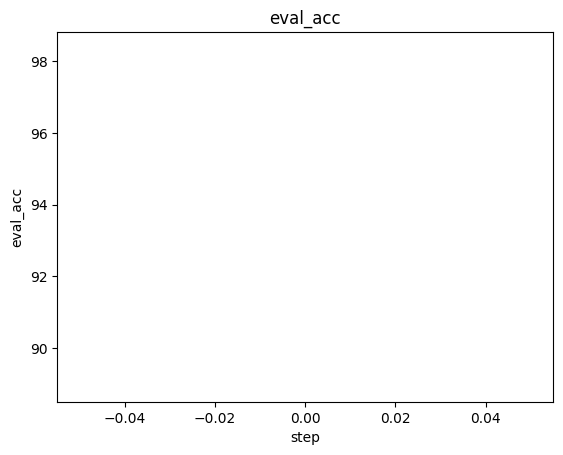

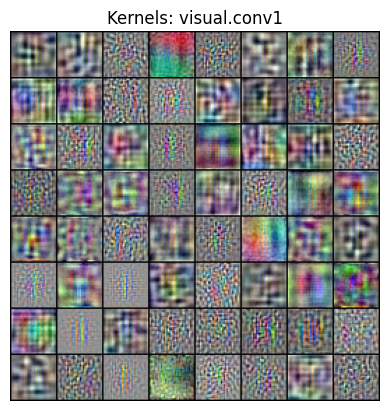

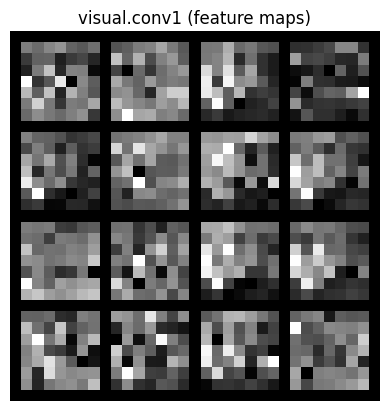

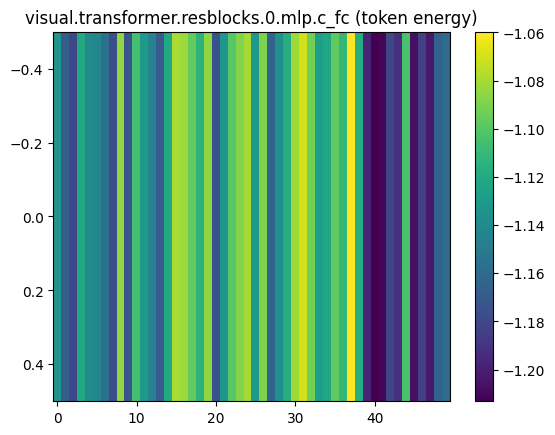

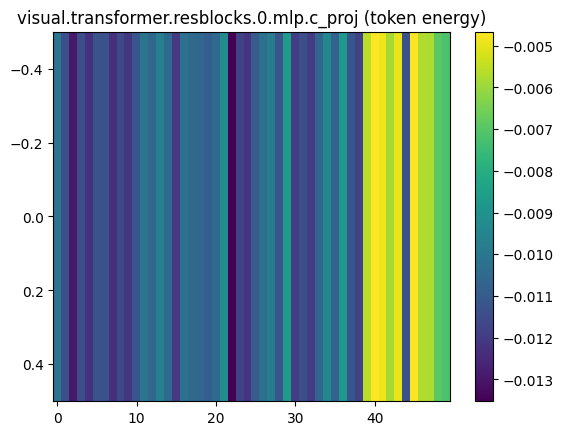

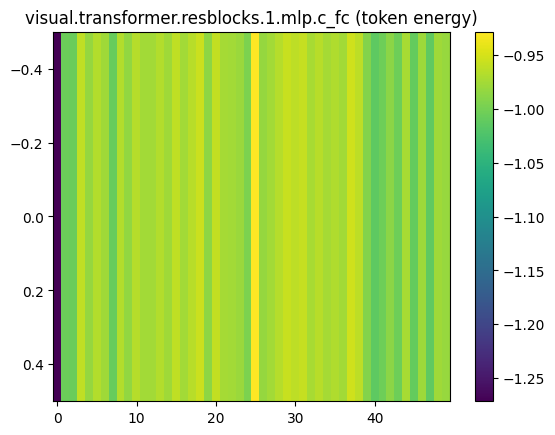

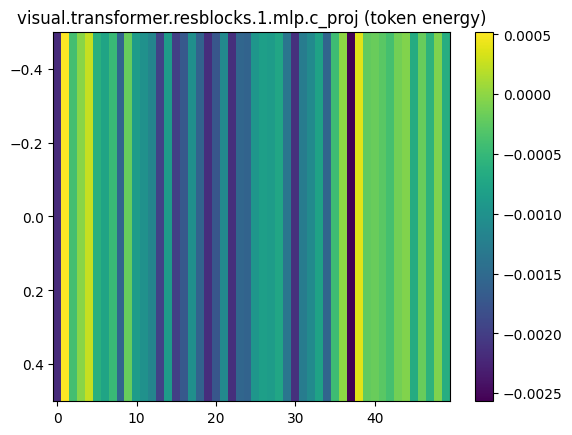

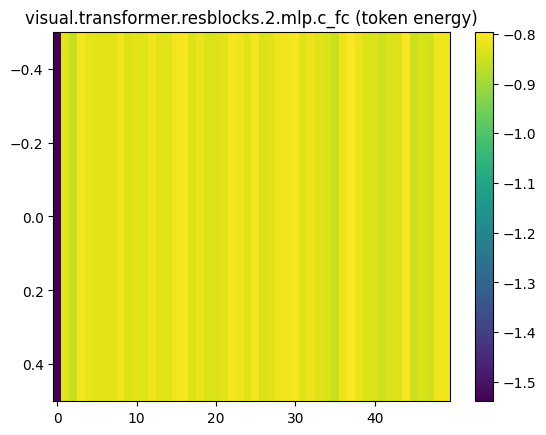

In [9]:
# === Choose a CLIP-family model ===
MODEL_NAME   = "ViT-B-32"
PRETRAINED   = "laion2b_s34b_b79k"  # from OpenCLIP

# --- Load model + preprocess ---
model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
model = model.to(device).eval()

# --- Data ---
train_loader, test_loader, classnames = get_cifar10(preprocess, DataConfig())

# --- Run zero-shot baseline ---
zs = METHODS["zero_shot"](model, tokenizer, classnames)
metrics = zs.evaluate(test_loader)
print(f"Zero-shot CIFAR-10 accuracy: {metrics['top1_acc']:.2f}%")

# --- Plot history (works across methods) ---
zs.history.plot(["eval_acc"])

# --- Visualize kernels (Conv2d only) ---
# For ViT, this will typically show the patch-embedding conv.
for name, m in model.named_modules():
    if isinstance(m, nn.Conv2d):
        viz_conv_kernels(m, max_k=64, title=f"Kernels: {name}")

# --- Capture and visualize activations from a few layers ---
# Pick a small batch
images, _ = next(iter(test_loader))
images = images[:8].to(device)

# Example: hook into visual encoder's first convs / early blocks
def pick_layers(n, m):
    return isinstance(m, (nn.Conv2d, nn.Linear)) and ("visual" in n or "patch" in n or "attn" in n)

acts, handles = register_activation_hooks(model, pick_layers)
with torch.no_grad():
    _ = model.encode_image(images)

# Show a few activation maps/histograms
shown = 0
for name, out in acts.items():
    viz_activations(out, title=name, max_maps=16)
    shown += 1
    if shown >= 6: break  # keep it short

# Always cleanup hooks in notebooks
for h in handles: h.remove()

In [10]:
## Not used yet
class SimpleTrainer:
    def __init__(self, model: nn.Module, criterion=None, optimizer=None, scheduler=None):
        self.model = model
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.history = History()

    def _accuracy(self, logits, y):
        return (logits.argmax(1) == y).float().mean().item() * 100.0

    def fit(self, train_loader, val_loader=None, epochs=1, step_eval_every=100, forward_fn: Optional[Callable]=None):
        """
        forward_fn(batch, model) -> (logits, loss)  # lets each method customize the forward
        """
        self.model.train()
        step = 0
        for ep in range(epochs):
            pbar = tqdm(train_loader, desc=f"Train e{ep+1}/{epochs}", leave=False)
            for batch in pbar:
                x, y = batch[0].to(device, non_blocking=True), batch[1].to(device, non_blocking=True)
                logits, loss = forward_fn((x,y), self.model)  # method-defined
                self.optimizer.zero_grad(set_to_none=True); loss.backward(); self.optimizer.step()
                if self.scheduler: self.scheduler.step()

                acc = self._accuracy(logits, y)
                self.history.update(train_loss=loss.item(), train_acc=acc)
                if step % step_eval_every == 0:
                    pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.1f}")
                step += 1

            if val_loader is not None:
                self.model.eval()
                v_loss = v_acc = n = 0
                with torch.no_grad():
                    for x, y in val_loader:
                        x, y = x.to(device), y.to(device)
                        logits, loss = forward_fn((x,y), self.model)
                        v_loss += loss.item()*x.size(0)
                        v_acc  += (logits.argmax(1)==y).sum().item()
                        n += x.size(0)
                v_loss /= n; v_acc = 100.0*v_acc/n
                self.history.update(val_loss=v_loss, val_acc=v_acc)
                print(f"[epoch {ep+1}] val_acc={v_acc:.2f}  val_loss={v_loss:.4f}")
                self.model.train()
        return self.history
